In [21]:
import numpy as np
import pandas as pd
from PIL import Image
import os
from glob import glob
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [22]:
# 读取数据
train = './train'
train_csv = pd.read_csv("./train.csv")
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115488 entries, 0 to 115487
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            115488 non-null  object
 1   class         115488 non-null  object
 2   segmentation  33913 non-null   object
dtypes: object(3)
memory usage: 2.6+ MB


In [23]:
train_csv.head()

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN


In [24]:
# 制作透视表
train_csv = pd.pivot_table(train_csv, values='segmentation', index='id',
                          columns='class',aggfunc=np.max).astype(str).fillna('')
train_csv = train_csv.reset_index()
train_csv.tail(10)

class,id,large_bowel,small_bowel,stomach
16580,case9_day22_slice_0110,38581 3 38922 1 38932 13 39103 8 39280 25 3946...,21364 6 21708 5 21722 10 22067 7 22081 12 2242...,nan
16581,case9_day22_slice_0111,38942 3 39106 4 39281 1 39293 13 39464 8 39639...,21362 8 21708 4 21720 12 22067 6 22079 14 2242...,nan
16582,case9_day22_slice_0112,38943 3 39107 3 39293 14 39465 7 39650 17 3982...,21362 8 21709 1 21720 11 22067 5 22078 14 2242...,nan
16583,case9_day22_slice_0113,39105 5 39292 14 39464 7 39649 18 39823 9 4000...,21362 7 21719 11 22068 3 22078 13 22426 6 2243...,nan
16584,case9_day22_slice_0114,38740 7 39100 9 39293 7 39460 11 39649 14 3982...,21361 7 21719 10 22077 13 22427 3 22436 15 227...,nan
16585,case9_day22_slice_0115,38022 2 38380 7 38739 9 39099 10 39295 6 39459...,21360 7 21718 10 22077 12 22435 15 22788 1 227...,nan
16586,case9_day22_slice_0116,38021 4 38379 8 38739 10 38938 2 39099 10 3929...,21361 3 21718 9 22076 12 22435 14 22794 17 231...,nan
16587,case9_day22_slice_0117,38020 7 38379 10 38738 12 38936 4 39098 12 392...,21717 8 22076 11 22434 15 22791 20 23149 25 23...,nan
16588,case9_day22_slice_0118,37661 5 38019 10 38378 12 38738 12 39097 14 39...,21359 6 21717 10 22074 15 22431 20 22790 23 23...,nan
16589,case9_day22_slice_0119,37658 11 38017 13 38377 13 38737 13 39097 13 3...,20998 7 21357 11 21714 15 22071 20 22430 22 22...,nan


In [25]:
# 遍历文件夹
x = glob(r'./train/**/*.png', recursive=True)
for i in range(len(x)):
    x[i] = x[i].replace("./", "")

In [26]:
# 根据图片名字获得图像信息
def setup_img_info(x):
    name = x.split('\\')[-1].split('_')
    img_name = ''
    img_name += x.split('\\')[-3] + '_' + name[0] + '_' + name[1]
    height, width, h_pixel, w_pixel = (name[2], name[3], 
                                       name[4], name[5].replace('png', ''))
    case = int(img_name.split("_")[0].replace("case", ""))
    day = int(img_name.split("_")[1].replace("day", ""))
    slice = int(img_name.split("_")[3])
    return pd.Series([img_name, case, day, slice, height, width, h_pixel, w_pixel])
image_detail = pd.DataFrame()
image_detail['img_path'] = x
image_detail[['id', 'case', 'day', 'slice', 'height', 'width', 'h_pixel', 'w_pixel']] = image_detail['img_path'].apply(lambda t: setup_img_info(t))

In [27]:
image_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38496 entries, 0 to 38495
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   img_path  38496 non-null  object
 1   id        38496 non-null  object
 2   case      38496 non-null  int64 
 3   day       38496 non-null  int64 
 4   slice     38496 non-null  int64 
 5   height    38496 non-null  object
 6   width     38496 non-null  object
 7   h_pixel   38496 non-null  object
 8   w_pixel   38496 non-null  object
dtypes: int64(3), object(6)
memory usage: 2.6+ MB


In [28]:
# 合并两个表
df2 = pd.merge(image_detail, train_csv, on='id')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16590 entries, 0 to 16589
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   img_path     16590 non-null  object
 1   id           16590 non-null  object
 2   case         16590 non-null  int64 
 3   day          16590 non-null  int64 
 4   slice        16590 non-null  int64 
 5   height       16590 non-null  object
 6   width        16590 non-null  object
 7   h_pixel      16590 non-null  object
 8   w_pixel      16590 non-null  object
 9   large_bowel  16590 non-null  object
 10  small_bowel  16590 non-null  object
 11  stomach      16590 non-null  object
dtypes: int64(3), object(9)
memory usage: 1.6+ MB


In [29]:
df2 = df2.rename(columns = {'large_bowel' : 'rle_large' , 
                            'small_bowel':'rle_small' ,'stomach':'rle_stomach'})
df2['count'] = np.sum(df2.iloc[:,9:12]!='nan',axis=1).values

df2.sample(5)

,img_path,id,case,day,slice,height,width,h_pixel,w_pixel,rle_large,rle_small,rle_stomach,count
6110,train\case141\case141_day27\scans\slice_0067_2...,case141_day27_slice_0067,141,27,67,266,266,1.50,1.50.,30513 6 30778 8 31043 10 31308 12 31574 12 318...,27260 9 27523 15 27787 18 28052 20 28316 23 28...,28357 14 28621 18 28887 20 29152 21 29417 23 2...,3
7965,train\case154\case154_day17\scans\slice_0069_2...,case154_day17_slice_0069,154,17,69,266,266,1.50,1.50.,21976 5 22241 11 22507 13 22772 16 23039 17 23...,26758 8 27022 18 27287 23 27553 25 27818 27 28...,22479 3 22743 6 23008 8 23274 8 23539 9 23804 ...,3
16317,train\case90\case90_day0\scans\slice_0109_266_...,case90_day0_slice_0109,90,0,109,266,266,1.50,1.50.,25933 7 26186 21 26451 23 26519 8 26716 24 267...,28395 5 28648 20 28912 22 29177 24 29442 27 29...,nan,2
12477,train\case49\case49_day13\scans\slice_0085_360...,case49_day13_slice_0085,49,13,85,360,310,1.50,1.50.,20307 4 20314 6 20664 19 21017 29 21375 34 217...,35424 5 35781 10 36139 14 36498 16 36550 9 368...,23233 20 23589 29 23946 35 24304 39 24662 43 2...,3
9167,train\case2\case2_day4\scans\slice_0114_266_26...,case2_day4_slice_0114,2,4,114,266,266,1.50,1.50.,25887 2 26151 7 26415 11 26679 15 26944 17 272...,24864 3 25128 7 25394 8 25660 8 25926 8 26192 ...,nan,2


In [30]:
train_df, test_df = train_test_split(df2, test_size=0.2)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(train_df.head())
print("\n \nNumber of Train Images:{}".format(len(train_df)))
print("Number of Test Images:{}".format(len(test_df)))


 
Number of Train Images:13272
Number of Test Images:3318


In [17]:
train_df.to_csv('./train_df.csv')
test_df.to_csv('./test_df.csv')

In [42]:
# 可视化
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from mmdet.apis import init_detector, inference_detector,show_result_pyplot

config_file = 'configs2/uw_madison_gi_tract/胃肠道图像分割.py'
checkpoint_file = 'work_dirs/胃肠道图像分割/latest.pth'
device = 'cuda:0'
model = init_detector(config_file, checkpoint_file, device=device)

def rle_to_mask(rle_string, heigth, width):
    rows, cols = heigth, width
    if rle_string == 'nan':
        return np.zeros(rows * cols, dtype=np.uint8).reshape(rows, cols)
    else:
        rle_numbers = [int(numstring) for numstring in rle_string.split(' ')]
        rle_pairs = np.array(rle_numbers).reshape(-1, 2)
        img = np.zeros(rows*cols, dtype=np.uint8)
        for index,length in rle_pairs:
            img[index:index+length] = 255
        img = img.reshape(rows, cols)
        return img

load checkpoint from local path: work_dirs/胃肠道图像分割/latest.pth


In [47]:
def visual(row,index):
    plt.figure(figsize=(20,20))
    image = cv2.imread(row['img_path'].iloc[index], cv2.IMREAD_UNCHANGED)
    print(row['img_path'].iloc[index])
    plt.subplot(1,4,1)
    plt.imshow(image)
    plt.subplot(1,4,2)
    plt.imshow(rle_to_mask(row['rle_large'].iloc[index],int(row['height'].iloc[index]),int(row['width'].iloc[index])))
    plt.subplot(1,4,3)
    plt.imshow(rle_to_mask(row['rle_small'].iloc[index],int(row['height'].iloc[index]),int(row['width'].iloc[index])))
    plt.subplot(1,4,4)
    plt.imshow(rle_to_mask(row['rle_stomach'].iloc[index],int(row['height'].iloc[index]),int(row['width'].iloc[index])))
#     result = inference_detector(model, img)
#     show_result_pyplot(model, image, result, score_thr=0.7)

train\case101\case101_day20\scans\slice_0066_266_266_1.50_1.50.png
train\case101\case101_day20\scans\slice_0086_266_266_1.50_1.50.png
train\case101\case101_day20\scans\slice_0106_266_266_1.50_1.50.png
train\case101\case101_day22\scans\slice_0076_266_266_1.50_1.50.png
train\case101\case101_day22\scans\slice_0096_266_266_1.50_1.50.png


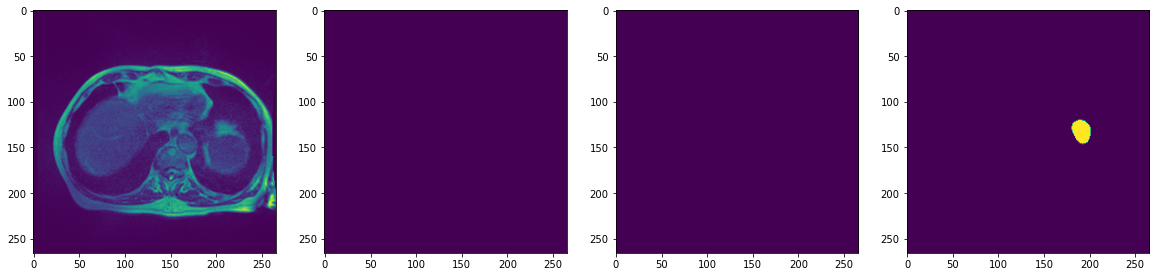

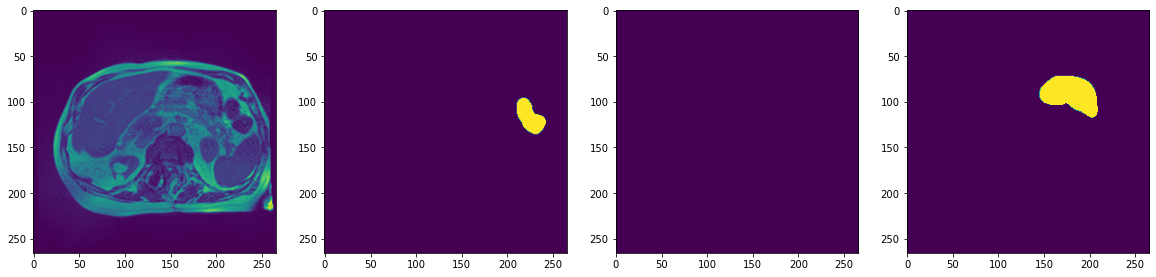

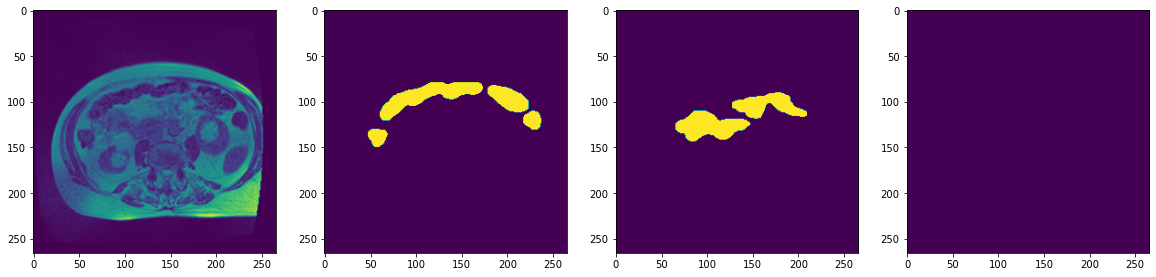

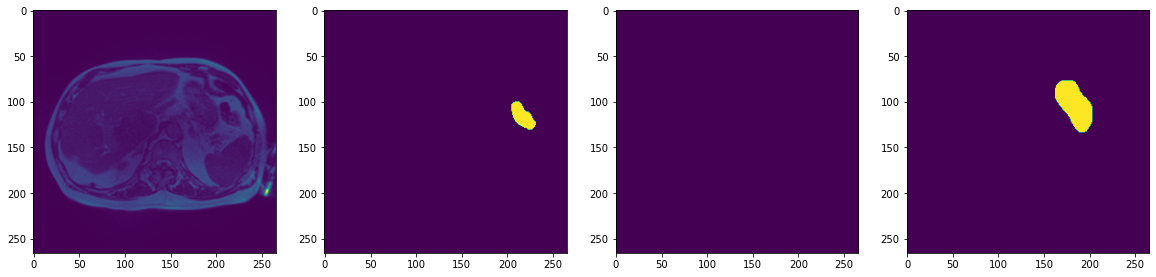

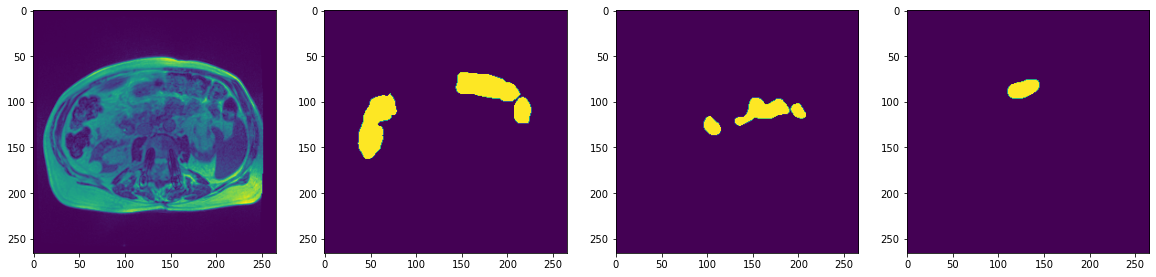

In [48]:
for i in range(0,100,20):
    visual(df2,i)

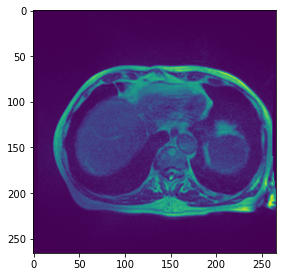

In [21]:
img = r'./train\case101\case101_day20\scans\slice_0066_266_266_1.50_1.50.png'
image = cv2.imread(img,  cv2.IMREAD_UNCHANGED)
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
plt.imshow(image)

In [51]:
import cv2
import matplotlib.pyplot as plt

from mmdet.apis import init_detector, inference_detector,show_result_pyplot

config_file = 'configs2/uw_madison_gi_tract/胃肠道图像分割.py'
# 从 model zoo 下载 checkpoint 并放在 `checkpoints/` 文件下
checkpoint_file = 'work_dirs/胃肠道图像分割/latest.pth'
device = 'cuda:0'
img = r'train\case101\case101_day22\scans\slice_0096_266_266_1.50_1.50.png'

# 初始化检测器
model = init_detector(config_file, checkpoint_file, device=device)
# 推理演示图像
result = inference_detector(model, img)

load checkpoint from local path: work_dirs/胃肠道图像分割/latest.pth


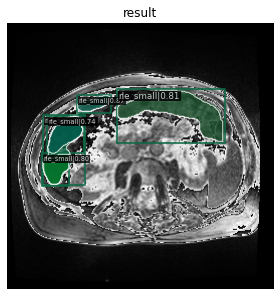

train\case101\case101_day22\scans\slice_0096_266_266_1.50_1.50.png


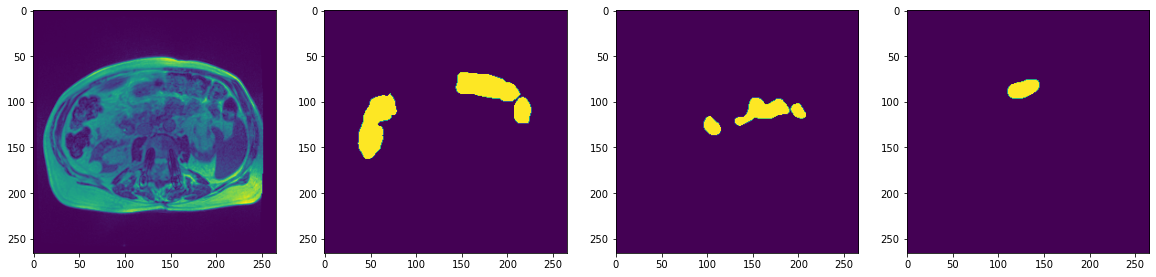

In [55]:
image = cv2.imread(img,  cv2.IMREAD_UNCHANGED)
show_result_pyplot(model, image, result, score_thr=0.7)
visual(df2,80)

In [17]:
result[0]

[array([[8.74561691e+01, 1.12687645e+02, 1.03428757e+02, 1.30913010e+02,
         7.16849744e-01],
        [1.42586121e+02, 9.62091370e+01, 1.87090790e+02, 1.16489883e+02,
         4.90763009e-01],
        [1.08759354e+02, 9.90506744e+01, 1.79492783e+02, 1.25500801e+02,
         4.27857041e-01],
        [8.55230331e+01, 1.13105957e+02, 1.13528793e+02, 1.33419220e+02,
         3.87697190e-01],
        [1.06600433e+02, 1.01818672e+02, 1.46541962e+02, 1.27508232e+02,
         3.02655160e-01],
        [8.85512543e+01, 1.06110077e+02, 1.42149780e+02, 1.33109360e+02,
         2.43328333e-01],
        [9.49784164e+01, 9.73875732e+01, 1.73049973e+02, 1.40280762e+02,
         2.32912555e-01],
        [1.68245758e+02, 9.94644699e+01, 1.84988495e+02, 1.14548897e+02,
         2.26474285e-01],
        [1.91263260e+02, 1.00092789e+02, 2.05615723e+02, 1.19473656e+02,
         2.23839477e-01],
        [1.03353798e+02, 7.33374252e+01, 2.20058395e+02, 1.43671661e+02,
         2.21571714e-01],
        [1